<a href="https://colab.research.google.com/github/lucasmsorrentino/FrameworksAI/blob/main/Ex04_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imagem carregada: (1, 341, 512, 3)

--- 1. Resultado Simples ---


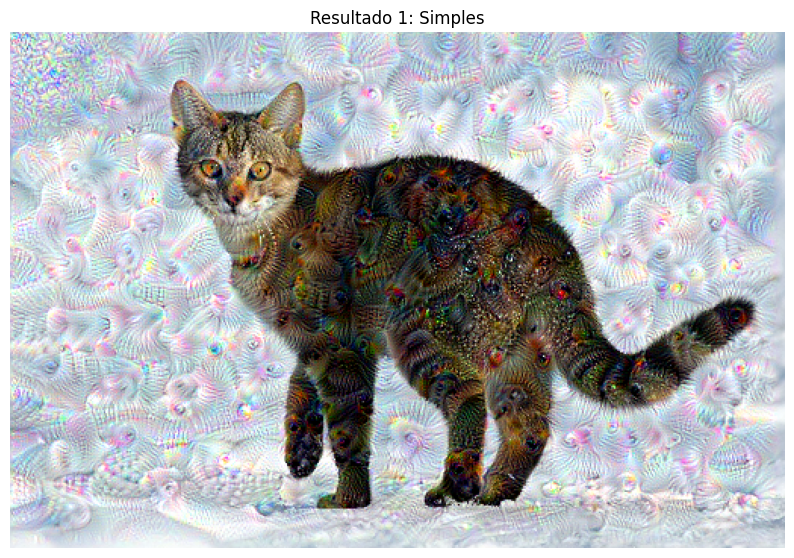

A processar Oitavas...
   Escala -2: [201 302]
   Escala -1: [262 393]
   Escala 0: [341 512]
   Escala 1: [443 665]
   Escala 2: [576 865]


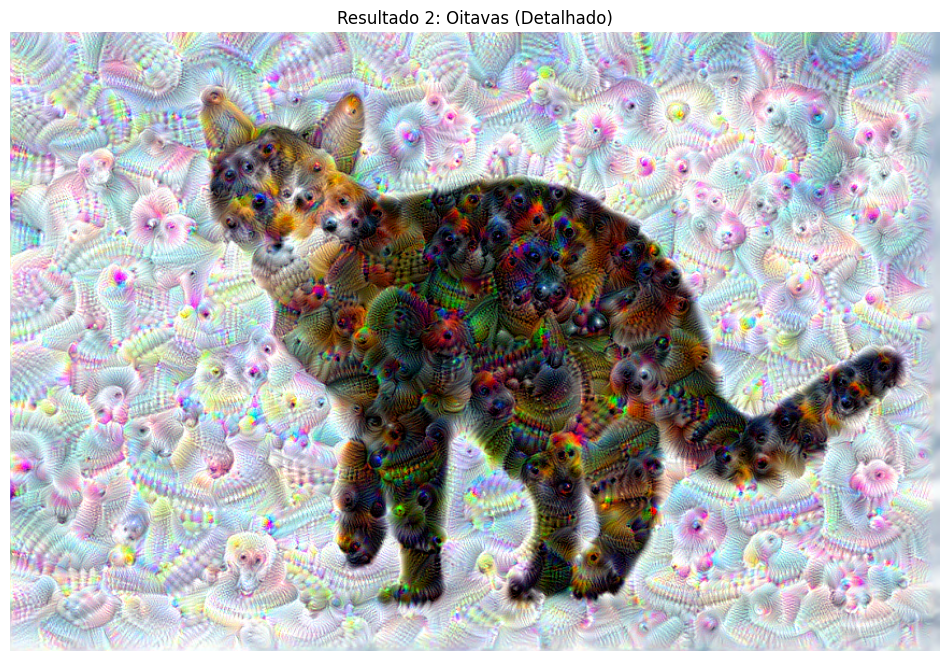

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import os

# ==========================================
# 1. PREPARAÇÃO E DOWNLOAD
# ==========================================
local_filename = 'cat_snow.jpg'
url_wiki = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg"

if not os.path.exists(local_filename):
    print("1. A baixar imagem...")
    os.system(f'curl -L -A "Mozilla/5.0" -o {local_filename} "{url_wiki}"')

# Função para carregar e formatar
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32) # Converte para 0..1

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :] # Adiciona batch dimension: (1, H, W, 3)
  return img

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

original_img = load_img(local_filename)
print(f"Imagem carregada: {original_img.shape}")

# ==========================================
# 2. MODELO E PERDA
# ==========================================
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Usamos camadas mistas para garantir padrões interessantes
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

def calc_loss(img, model):
  # Passa a imagem pelo modelo
  layer_activations = model(img)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

@tf.function
def deepdream_step(img, step_size, net):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, net)

    gradients = tape.gradient(loss, img)

    # Normalização dos gradientes (Evita que a imagem fique cinza ou exploda)
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    # Gradient Ascent
    img = img + gradients * step_size
    img = tf.clip_by_value(img, -1, 1) # Mantém no range do Inception

    return loss, img

# ==========================================
# 3. LÓGICA DE OITAVAS (CORRIGIDA)
# ==========================================
# ==========================================
# CORREÇÃO DA FUNÇÃO DE OITAVAS
# ==========================================
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-2, 3), octave_scale=1.3):

    # 1. Pré-processamento
    img = tf.keras.applications.inception_v3.preprocess_input(img * 255.0)

    # Obtemos o tamanho base (Altura, Largura) como inteiros
    base_shape = tf.shape(img)[1:-1]

    print("Oitavas...")

    for octave in octaves:
        # CORREÇÃO AQUI: Usamos tf.cast para converter int32 -> float32 explicitamente
        new_shape_float = tf.cast(base_shape, tf.float32) * (octave_scale**octave)
        new_shape = tf.cast(new_shape_float, tf.int32)

        # Redimensionar
        img = tf.image.resize(img, new_shape)

        print(f"   Escala {octave}: {new_shape.numpy()}")

        # Rodar DeepDream nesta escala
        for step in range(steps_per_octave):
            loss, img = deepdream_step(img, step_size, dream_model)

    # 2. Desprocessamento final
    result = deprocess(img)
    return result


# ==========================================
# 4. EXECUTAR E MOSTRAR
# ==========================================

# A. Imagem Simples (Sem zoom)

print("\n--- 1. Resultado Simples ---")
# Para o simples, rodamos apenas 1 escala
img_simple = tf.keras.applications.inception_v3.preprocess_input(original_img * 255.0)
for _ in range(100):
    _, img_simple = deepdream_step(img_simple, 0.01, dream_model)
res_simple = deprocess(img_simple)

plt.figure(figsize=(10,10))
plt.imshow(res_simple[0])
plt.title("Resultado 1: Simples")
plt.axis('off')
plt.show()

print("\n--- 2. Resultado com Oitavas (Tentativa Final) ---")

res_octave = run_deep_dream_with_octaves(
    original_img,
    steps_per_octave=50,
    step_size=0.01,
    octaves=range(-2, 3),
    octave_scale=1.3
)

plt.figure(figsize=(12,12))
plt.imshow(res_octave[0])
plt.title("Resultado 2: Oitavas (Detalhado)")
plt.axis('off')
plt.show()


Explicação dos Resultados (Relatório DeepDream)
1. Imagem onírica obtida por Main Loop (Simples)

>>"Na abordagem simples (Main Loop), o algoritmo DeepDream é aplicado diretamente na imagem original em resolução fixa. Como a rede neural (InceptionV3) analisa a imagem apenas numa única escala, ela tende a identificar e reforçar apenas padrões de texturas superficiais e repetitivas (como pequenos olhos, espirais ou pelos). O resultado final é uma imagem que parece ter um 'filtro' texturizado por cima, mas a estrutura global do gato e da neve permanece praticamente inalterada, pois a rede não teve oportunidade de 'imaginar' objetos maiores."

2. Imagem onírica obtida com Oitavas (Multiescala)

>>"Na abordagem com Oitavas, utiliza-se uma técnica de multiescala: a imagem é reduzida (zoom out) e o DeepDream é aplicado sucessivamente desde a versão mais pequena até à original.
    

>> * Nas escalas menores (baixa resolução): A rede neural consegue 'ver' a imagem como um todo e sugere grandes estruturas ou objetos novos (transformando o corpo do gato noutros animais ou criando formas geométricas grandes).

>> * Nas escalas maiores (alta resolução): À medida que aumentamos o tamanho (zoom in), a rede preenche essas novas formas com detalhes finos. O resultado é uma imagem muito mais rica e alucinógena, onde o conteúdo original se funde com interpretações complexas da IA."


3. Diferenças entre as duas abordagens

>>"A principal diferença reside na complexidade e profundidade das alucinações:

>> * Main Loop: Gera apenas ruído visual e texturas finas. É superficial.

>> * Oitavas: Gera objetos coerentes e novas formas. É estrutural.

>> Enquanto o Main Loop preserva a identidade da foto original apenas adicionando 'sujeira' artística, o método de Oitavas reinterpreta a cena, criando uma composição visualmente muito mais impactante e que demonstra melhor a capacidade criativa da rede neural em encontrar padrões onde eles não existem."